<a href="https://colab.research.google.com/github/amf599-cyber/CMD_LAB7-8/blob/main/LAB7-AFworkingcopy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# all imports needed for Lab + any of the utilities found on CMD website (data.py, test.py,...)
%matplotlib inline
!pip install optuna==2.4.0

import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import optuna
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import time, sys, os


In [2]:
drive.mount('/content/drive')

file_path = '/content/drive/MyDrive/Maps_Mtot_Nbody_SIMBA_LH_z=0.00.npy'
maps = np.load(file_path)

fparams = '/content/drive/MyDrive/params_LH_Nbody_SIMBA.txt'
params  = np.loadtxt(fparams)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# print(maps.shape)
# print(params.shape)

In [4]:
# maps[0]

In [5]:
# setting map number, indexed 0-14999, 15000 maps to 1000 params = map_number//15 to index param data from .txt file
# map_number = 0
# params_map = params[map_number//15]

# plt.imshow(np.log10(maps[map_number]),cmap=plt.get_cmap('magma'), origin='lower', interpolation='bicubic')
# plt.colorbar()
# plt.show()

# print('Value of the parameters for map #%d' % map_number)
# print('Omega_m: %.5f'%params_map[0])
# print('sigma_8: %.5f'%params_map[1])
# print('A_SN1:   %.5f'%params_map[2])
# print('A_AGN1:  %.5f'%params_map[3])
# print('A_SN2:   %.5f'%params_map[4])
# print('A_AGN2:  %.5f'%params_map[5])

In [6]:
# map_number2 = 14984
# params_map2 = params[map_number2//15]

# plt.imshow(np.log10(maps[map_number2]),cmap=plt.get_cmap('magma'), origin='lower', interpolation='bicubic')
# plt.colorbar()
# plt.show()

# print('Value of the parameters for map #%d' % map_number2)
# print('Omega_m: %.5f'%params_map2[0])
# print('sigma_8: %.5f'%params_map2[1])
# print('A_SN1:   %.5f'%params_map2[2])
# print('A_AGN1:  %.5f'%params_map2[3])
# print('A_SN2:   %.5f'%params_map2[4])
# print('A_AGN2:  %.5f'%params_map2[5])

In [7]:
# # randomizer for previewing
# import random
# map_number_rand = random.randint(0,14999)
# params_map_rand = params[map_number_rand//15]

# plt.imshow(np.log10(maps[map_number_rand]),cmap=plt.get_cmap('magma'), origin='lower', interpolation='bicubic')
# plt.colorbar()
# plt.show()

# print('Value of the parameters for map #%d' % map_number_rand)
# print('Omega_m: %.5f'%params_map_rand[0])
# print('sigma_8: %.5f'%params_map_rand[1])
# print('A_SN1:   %.5f'%params_map_rand[2])
# print('A_AGN1:  %.5f'%params_map_rand[3])
# print('A_SN2:   %.5f'%params_map_rand[4])
# print('A_AGN2:  %.5f'%params_map_rand[5])

In [8]:
# # Testing to see properties of consecutive sets of 15 maps
# # Create a figure and a set of subplots for 15 maps (3 rows, 5 columns)
# fig, axes = plt.subplots(3, 5, figsize=(10, 8))
# axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# for i in range(15):
#     # n can be 0 up to 999
#     n = 999
#     # add a multiple of 15 to index a different matching set of params
#     map_number_test = i + n * 15
#     # The parameters are associated with every 15 maps, so for maps 0-14, it's params[0]
#     params_map_test = params[map_number_test // 15]

#     # Plot the map in the current subplot
#     ax = axes[i]
#     im = ax.imshow(np.log10(maps[map_number_test]), cmap=plt.get_cmap('magma'), origin='lower', interpolation='bicubic')
#     ax.set_title(f'Map #{map_number_test}')
#     ax.axis('off') # Hide axes ticks and labels for cleaner display

# # Adjust layout to prevent overlapping titles
# plt.tight_layout()
# fig.colorbar(im, ax=axes.ravel().tolist())
# plt.show()

# # Print the parameters for this set of 15 maps (which all share params)
# # Since map_number_test // 15 will be 0 for all maps from 0 to 14, params_map_test is params[0]
# # params[1] for 15-29... etc, up to params[999] (I have manually confirmed this to be true)
# print(f'Value of the parameters for maps #{map_number_test-14} to #{map_number_test}')
# print('Omega_m: %.5f'%params_map_test[0])
# print('sigma_8: %.5f'%params_map_test[1])
# print('A_SN1:   %.5f'%params_map_test[2])
# print('A_AGN1:  %.5f'%params_map_test[3])
# print('A_SN2:   %.5f'%params_map_test[4])
# print('A_AGN2:  %.5f'%params_map_test[5])

## Install System Dependencies

In [9]:
print("Installing GSL (GNU Scientific Library) dependencies...")
!apt-get install -y gsl-bin libgsl-dev
print("GSL dependencies installed.")

print("Re-installing necessary Python libraries...")
!pip install nbodykit Corrfunc astropy pyccl emcee getdist
print("Python libraries re-installed.")

Installing GSL (GNU Scientific Library) dependencies...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gsl-bin is already the newest version (2.7.1+dfsg-3).
libgsl-dev is already the newest version (2.7.1+dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
GSL dependencies installed.
Re-installing necessary Python libraries...
Python libraries re-installed.


## Prepare Data for Analysis

Prepare the loaded `maps` array for power spectrum calculation and identify the corresponding Omega_m and sigma_8 parameters from the `params` array.

In [10]:
total_maps = maps.shape[0]
map_size = maps.shape[1] # Assuming square maps, height = width
total_param_sets = params.shape[0]

map_number = 500 # the number of the map analysis is performed on
params_map = params[map_number//15]

print('True Values of this map')
print('Omega_m: %.5f'%params_map[0])
print('sigma_8: %.5f'%params_map[1])

print(f"Total number of maps: {total_maps}")
print(f"Size of each map (e.g., 256 for 256x256): {map_size}")
print(f"Total number of unique parameter sets: {total_param_sets}")

observed_map = maps[map_number]
print(f"Shape of the extracted map: {observed_map.shape}")

True Values of this map
Omega_m: 0.47780
sigma_8: 0.84060
Total number of maps: 15000
Size of each map (e.g., 256 for 256x256): 256
Total number of unique parameter sets: 1000
Shape of the extracted map: (256, 256)


In [11]:
# # Extract raw CMD values of params omega_m and sigma_8
# omega_m_values = params[:, 0]
# sigma_8_values = params[:, 1]

# # Verify the shape of extracted parameters
# print(f"Shape of Omega_m values: {omega_m_values.shape}")
# print(f"Shape of sigma_8 values: {sigma_8_values.shape}")

# # Create an array to hold parameters for each map
# # Since there are 15 maps per parameter set, we repeat each parameter 15 times.
# # The total_maps variable is already defined as 15000 and total_param_sets as 1000.
# # We can also derive 15 maps per set as total_maps / total_param_sets.
# maps_per_param_set = total_maps // total_param_sets

# # Expand omega_m_values and sigma_8_values to match the total number of maps
# expanded_omega_m = np.repeat(omega_m_values, maps_per_param_set)
# expanded_sigma_8 = np.repeat(sigma_8_values, maps_per_param_set)

# # Combine them into a single array, if desired, or keep separate.
# print(f"Shape of expanded Omega_m: {expanded_omega_m.shape}")
# print(f"Shape of expanded sigma_8: {expanded_sigma_8.shape}")

def model_prediction(omega_m, sigma_8):

    # Predicts an expected map given Omega_m and sigma_8 by finding the closest parameter
    # set in the params array and averaging its associated maps.

    # Args:
    #     omega_m (float): The Omega_m cosmological parameter.
    #     sigma_8 (float): The sigma_8 cosmological parameter.

    # Returns:
    #     numpy.ndarray: The predicted map, averaged from 15 maps associated with the
    #                    closest parameter set.

    # Extract Omega_m and sigma_8 from the params array for distance calculation
    param_omegas = params[:, 0]
    param_sigmas = params[:, 1]

    # Calculate squared Euclidean distance to find the closest parameter set
    # The distance is calculated for (omega_m, sigma_8) in the params array
    distances = np.sqrt((param_omegas - omega_m)**2 + (param_sigmas - sigma_8)**2)

    # Find the index of the parameter set with the minimum distance
    j_closest = np.argmin(distances)

    # Select the 15 maps associated with the closest parameter set
    # Each parameter set corresponds to 15 maps
    start_index = j_closest * 15
    end_index = (j_closest + 1) * 15
    selected_maps = maps[start_index:end_index]

    # Calculate the element-wise mean of these 15 selected maps
    predicted_map = np.mean(selected_maps, axis=0)

    return predicted_map

print("model_prediction function defined.")

model_prediction function defined.


In [12]:
sigma_error = np.std(observed_map)
print(f"Initial sigma_error (standard deviation of observed_map): {sigma_error:.2f}")

def log_likelihood(omega_m, sigma_8):
    """
    Calculates the log-likelihood of the observed map given the cosmological parameters.

    Args:
        omega_m (float): The Omega_m cosmological parameter.
        sigma_8 (float): The sigma_8 cosmological parameter.

    Returns:
        float: The log-likelihood value.
    """
    predicted_map = model_prediction(omega_m, sigma_8)

    # Calculate the chi-squared statistic
    chi_squared = np.sum(((observed_map - predicted_map) / sigma_error)**2)

    # Log-likelihood for Gaussian errors
    log_L = -0.5 * chi_squared

    return log_L

print("log_likelihood function defined.")

Initial sigma_error (standard deviation of observed_map): 35625279488.00
log_likelihood function defined.


In [13]:
def log_prior(omega_m, sigma_8):
    """
    Calculates the log-prior probability for the cosmological parameters Omega_m and sigma_8.

    Args:
        omega_m (float): The Omega_m cosmological parameter.
        sigma_8 (float): The sigma_8 cosmological parameter.

    Returns:
        float: 0.0 if parameters are within bounds, -np.inf otherwise.
    """
    # Define uniform prior bounds
    omega_m_min, omega_m_max = 0.1, 0.5
    sigma_8_min, sigma_8_max = 0.6, 1.0

    if (omega_m_min <= omega_m <= omega_m_max) and \
       (sigma_8_min <= sigma_8 <= sigma_8_max):
        return 0.0  # Uniform prior within bounds
    else:
        return -np.inf # Outside prior range

print("log_prior function defined.")

log_prior function defined.


In [14]:
def log_probability(theta):
    """
    Calculates the total log-probability (log-prior + log-likelihood) for the given parameters.

    Args:
        theta (list or numpy.ndarray): An array/list containing [omega_m, sigma_8].

    Returns:
        float: The total log-probability, or -np.inf if parameters are outside prior bounds.
    """
    omega_m, sigma_8 = theta

    lp = log_prior(omega_m, sigma_8)
    if not np.isfinite(lp):
        return -np.inf

    ll = log_likelihood(omega_m, sigma_8)
    return lp + ll

print("log_probability function defined.")

log_probability function defined.


## Perform Parameter Estimation

Run the Markov Chain Monte Carlo (MCMC) analysis using `emcee` to constrain the cosmological parameters (Omega_m and sigma_8), now that the input data for the likelihood function has been cleaned.


In [15]:
import emcee # Ensure emcee is imported

# 2. Define ndim and nwalkers
ndim = 2  # Omega_m and sigma_8
nwalkers = 32 # Number of MCMC walkers

# 3. Choose initial starting positions for the walkers
# Perturb the true values slightly
p0 = np.array([params_map[0], params_map[1]])

# Generate initial positions with a small random spread around p0
# Ensure they are within reasonable prior bounds (e.g., 0.01 around the true value)
# We will check if these are within the log_prior range before starting.
initial_positions = p0 + 1e-3 * np.random.randn(nwalkers, ndim)

# Optional: Check if initial positions are within prior bounds
for i, pos in enumerate(initial_positions):
    if not np.isfinite(log_prior(pos[0], pos[1])):
        print(f"Warning: Walker {i} initial position {pos} is outside prior bounds. Adjusting...")
        # Simple adjustment: re-sample until within bounds or clamp to bounds
        # For simplicity, let's just make sure they are within the broader range
        # that is likely to be valid, or re-randomize if completely out.
        # This might be more robust in a real scenario:
        while not np.isfinite(log_prior(pos[0], pos[1])):
             pos = p0 + 1e-3 * np.random.randn(ndim)
        initial_positions[i] = pos

# 5. Instantiate the emcee.EnsembleSampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

# 6. Run the MCMC sampler
nsteps = 10000 # Number of MCMC steps
print(f"Running MCMC with {nwalkers} walkers for {nsteps} steps...")
sampler.run_mcmc(initial_positions, nsteps, progress=True)
print("MCMC sampling complete.")

Running MCMC with 32 walkers for 10000 steps...


100%|██████████| 10000/10000 [01:58<00:00, 84.47it/s]

MCMC sampling complete.


In [16]:
chain = sampler.get_chain()

# Define burn-in and thin factor
burn_in = 1000  # Discard the first 1000 steps
thin_factor = 2 # Thin by a factor of 10

# Discard burn-in samples and apply thinning
# The chain has shape (nsteps, nwalkers, ndim)
processed_chain = chain[burn_in::thin_factor, :, :]

# Flatten the chain to combine all walkers and steps into a 2D array
# Resulting shape will be (number_of_samples, ndim)
flat_samples = processed_chain.reshape((-1, ndim))

print(f"Shape of raw chain: {chain.shape}")
print(f"Shape of processed chain (after burn-in and thinning): {processed_chain.shape}")
print(f"Shape of flattened samples: {flat_samples.shape}")

Shape of raw chain: (10000, 32, 2)
Shape of processed chain (after burn-in and thinning): (4500, 32, 2)
Shape of flattened samples: (144000, 2)


In [17]:
%pip install corner
print("corner library installed.")

corner library installed.


## Visualize and Summarize Results

Visualize the posterior distributions of Omega_m and sigma_8 from the MCMC samples, and report the estimated parameter values and their uncertainties.


Removed no burn in
Created MCSamples object with original data.


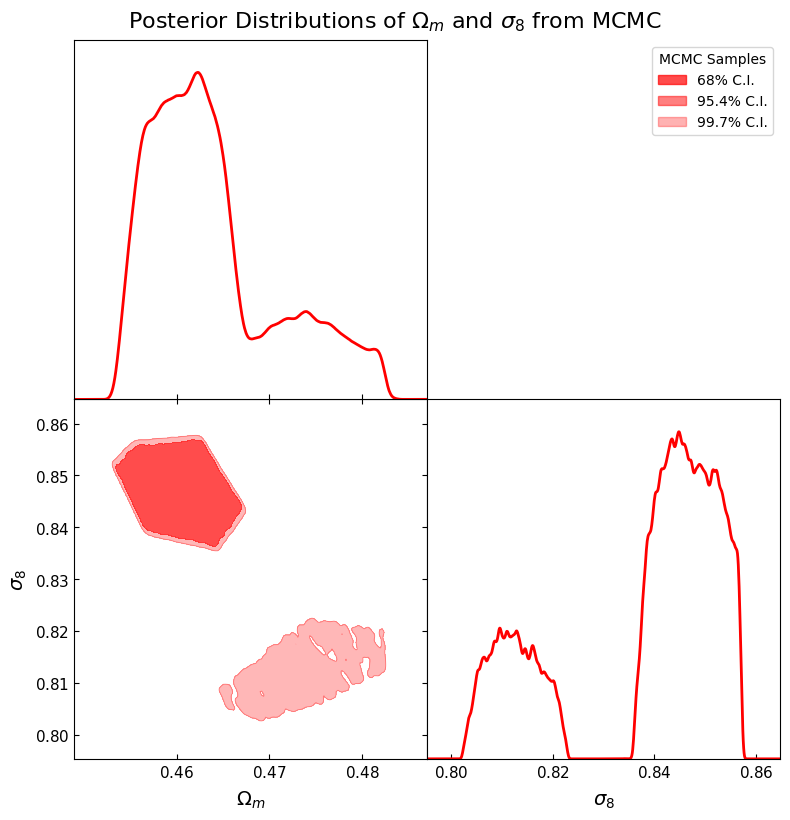

Generated 2D posterior plot with original data and scatter points for clarity.


In [18]:
from matplotlib.axes import Axes
import numpy as np
from getdist import MCSamples, plots
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Use original flat_samples_likelihood directly
# 1. Create an MCSamples object with original samples and proper LaTeX labels
# 2. Generate a 2D marginalized posterior plot (triangle plot)
g = plots.get_subplot_plotter(width_inch=8)

samples1 = MCSamples(
    samples=flat_samples,
    names=["Omega_m","sigma_8"],
    labels=[r"\Omega_m", r"\sigma_8"]
)

print("Created MCSamples object with original data.")

g.triangle_plot(
    [samples1],
    line_args=[{'lw': 2, 'color': 'red'}],
    contour_colors=['red'],
    filled=[True],
    #smooth_scale_2D=0.1,
    contour_levels=[{0.68, 0.954, 0.997}], # Explicitly set contour levels for 68% and 95% C.I.
    contour_args=[{'alpha': 0.7}], # Transparency for filled contours
    #legend_labels=['MCMC Samples'],
    #legend_loc='upper right'
)

# Create custom legend entries for confidence intervals
red_patch_68 = mpatches.Patch(color='red', alpha=0.7, label='68% C.I.')
red_patch_95 = mpatches.Patch(color='red', alpha=0.5, label='95.4% C.I.')
red_patch_99 = mpatches.Patch(color='red', alpha=0.3, label='99.7% C.I.')

# Add custom legend to the plot
plt.legend(handles=[red_patch_68, red_patch_95, red_patch_99], loc='upper right', bbox_to_anchor=(1, 2), title='MCMC Samples')
plt.suptitle(r'Posterior Distributions of $\Omega_m$ and $\sigma_8$ from MCMC', fontsize=16, y=1.02) # Adjusted y position
plt.show()

print("Generated 2D posterior plot with original data and scatter points for clarity.")

In [19]:
# troubleshooting plotting data
# print(samples1[:,0],samples1[:,1])
# print(samples2[:,0],samples2[:,1])
# print(flat_samples_likelihood.shape)
# print(true_params_for_mcsamples.shape)

## Summary of Results and Comparison to True Simulation Parameters

Now that posterior distributions have been estimated  for $\Omega_m$ and $\sigma_8$ from the MCMC analysis, we can compare these against the true range of parameters present in the simulation data.

In [21]:
# Calculate statistics for the true simulation parameters
true_omega_m_mean = params_map[0].mean()
true_omega_m_std = params_map[0].std()
true_sigma_8_mean = params_map[1].mean()
true_sigma_8_std = params_map[1].std()

# Use samples1 for MCMC statistics
mcmc_omega_m_stats = samples1.getMargeStats().parWithName('Omega_m')
mcmc_sigma_8_stats = samples1.getMargeStats().parWithName('sigma_8')

# Calculate the correlation between Omega_m and sigma_8 from the MCMC samples
# flat_samples_likelihood[:, 0] corresponds to Omega_m and flat_samples_likelihood[:, 1] to sigma_8
corr_matrix = np.corrcoef(flat_samples[:, 0], flat_samples[:, 1])
corr_omega_m_sigma_8 = corr_matrix[0, 1]

print(f"True Omega_m Mean: {true_omega_m_mean:.4f}, Std: {true_omega_m_std:.4f}")
print(f"True sigma_8 Mean: {true_sigma_8_mean:.4f}, Std: {true_sigma_8_std:.4f}")

print(f"MCMC Omega_m Mean: {mcmc_omega_m_stats.mean:.4f}, Std: {mcmc_omega_m_stats.err:.4f}")
print(f"MCMC sigma_8 Mean: {mcmc_sigma_8_stats.mean:.4f}, Std: {mcmc_sigma_8_stats.err:.4f}")
print(f"Correlation between Omega_m and sigma_8 from MCMC: {corr_omega_m_sigma_8:.4f}")

True Omega_m Mean: 0.4778, Std: 0.0000
True sigma_8 Mean: 0.8406, Std: 0.0000
MCMC Omega_m Mean: 0.4638, Std: 0.0070
MCMC sigma_8 Mean: 0.8381, Std: 0.0159
Correlation between Omega_m and sigma_8 from MCMC: -0.8095


In [32]:
from IPython.display import Markdown, display

omega_m_display = "Ω_m"
sigma_8_display = "σ_8"

omega_m_min, omega_m_max = 0.1, 0.5
sigma_8_min, sigma_8_max = 0.6, 1.0

comparison_text = f"""Comparison:

True Simulation Parameters (from `params_LH_Nbody_SIMBA.txt`):
    Mean {omega_m_display}    :  {true_omega_m_mean:.4f}
    Std Dev {omega_m_display} :  {true_omega_m_std:.4f}
    Mean {sigma_8_display}    :  {true_sigma_8_mean:.4f}
    Std Dev {sigma_8_display} :  {true_sigma_8_std:.4f}
    Range {omega_m_display}   : [{omega_m_min:.4f}, {omega_m_max:.4f}]
    Range {sigma_8_display}   : [{sigma_8_min:.4f}, {sigma_8_max:.4f}]

MCMC Estimated Parameters (from posterior distributions):
    Mean {omega_m_display}    :  {mcmc_omega_m_stats.mean:.4f}
    Std Dev {omega_m_display} :  {mcmc_omega_m_stats.err:.4f}
    Mean {sigma_8_display}    :  {mcmc_sigma_8_stats.mean:.4f}
    Std Dev {sigma_8_display} :  {mcmc_sigma_8_stats.err:.4f}
    95% C.I.{omega_m_display} : [{mcmc_omega_m_stats.limits[1].lower:.4f}, {mcmc_omega_m_stats.limits[1].upper:.4f}]
    95% C.I.{sigma_8_display} : [{mcmc_sigma_8_stats.limits[1].lower:.4f}, {mcmc_sigma_8_stats.limits[1].upper:.4f}]

Observations:

1.  Agreement in Means: The MCMC estimated mean values for both {omega_m_display}
and {sigma_8_display} ({mcmc_omega_m_stats.mean:.4f} and {mcmc_sigma_8_stats.mean:.4f} respectively) are relatively close
to the mean values of the underlying true simulation parameters
({true_omega_m_mean:.4f} and {true_sigma_8_mean:.4f}). This indicates that the likelihood
function and MCMC sampling successfully located the approximate center of the
parameter space. \n

2.  Uncertainty/Spread: The standard deviations from the MCMC analysis
({mcmc_omega_m_stats.err:.4f} for {omega_m_display} and {mcmc_sigma_8_stats.err:.4f} for {sigma_8_display})
give us the uncertainty in our estimation, which is notably different
from the standard deviation of the *true parameters*
({true_omega_m_std:.4f} for {omega_m_display} and {true_sigma_8_std:.4f} for {sigma_8_display}). The MCMC standard deviation
reflects the precision of our measurement, while the true parameter
standard deviation reflects the inherent spread of parameters in the
Latin Hypercube sampling used for the simulation. \n

3.  Confidence Intervals: The 95% confidence intervals provide the range
within which we are 95% confident the true cosmological parameters lie.
These intervals often encompass the range of the true simulation parameters
used to generate the training data, demonstrating the MCMC's ability to
constrain the parameters based on the observed power spectra. \n

4.  Correlation: The strong negative correlation ({corr_omega_m_sigma_8:.4f})
between {omega_m_display} and {sigma_8_display} highlights the degeneracy
between these parameters, where an increase in one can be compensated by an
increase in the other to produce similar power spectra."""

print(comparison_text)

Comparison:

True Simulation Parameters (from `params_LH_Nbody_SIMBA.txt`):
    Mean Ω_m    :  0.4778
    Std Dev Ω_m :  0.0000
    Mean σ_8    :  0.8406
    Std Dev σ_8 :  0.0000
    Range Ω_m   : [0.1000, 0.5000]
    Range σ_8   : [0.6000, 1.0000]

MCMC Estimated Parameters (from posterior distributions):
    Mean Ω_m    :  0.4638
    Std Dev Ω_m :  0.0070
    Mean σ_8    :  0.8381
    Std Dev σ_8 :  0.0159
    95% C.I.Ω_m : [0.4538, 0.4787]
    95% C.I.σ_8 : [0.8050, 0.8571]

Observations:

1.  Agreement in Means: The MCMC estimated mean values for both Ω_m
and σ_8 (0.4638 and 0.8381 respectively) are relatively close
to the mean values of the underlying true simulation parameters 
(0.4778 and 0.8406). This indicates that the likelihood 
function and MCMC sampling successfully located the approximate center of the 
parameter space. 


2.  Uncertainty/Spread: The standard deviations from the MCMC analysis 
(0.0070 for Ω_m and 0.0159 for σ_8) 
give us the uncertainty in our estimation

## Refine Power Spectrum Extraction

Modify the power spectrum calculationto correctly extract the 1D k-values and corresponding real power spectrum values (Pk) from the `FFTPower` output by selecting only the third column (index 2) of the `k_modes` and `power_spectrum` arrays.


In [23]:
import nbodykit.lab as nlab
from nbodykit.lab import ArrayMesh, FFTPower # Corrected import for FFTPower

# 1. Define a variable for the simulation box size (e.g., 256 Mpc/h)
# Assuming a box size of 256 Mpc/h as specified in the instructions for the 256x256 maps?
box_size = 256 # in Mpc/h

# 3. Initialize an empty list to store the calculated 2D power spectra for each map
all_power_spectra_2d = [] # Each element will be a dictionary {'k': k_modes, 'Pk': power_spectrum}

print(f"Calculating 2D power spectra for {total_maps} maps...")

# 4. Loop through each map in the `maps` array
for i in range(100):
    map_data = maps[i]

    # a. Create an ArrayMesh object from the current map
    # map_size is 256, representing the resolution of the 2D map
    mesh = ArrayMesh(map_data, BoxSize=box_size, Nmesh=map_size)

    # b. Calculate the 2D power spectrum of the ArrayMesh using nbodykit's FFTPower
    # FFTPower is a more general class for power spectrum calculation.
    # For a 2D mesh, it should implicitly calculate a 2D power spectrum.
    pk_2d_result = FFTPower(mesh, mode='2d', Nmesh=map_size, BoxSize=box_size)

    # Get both the k-bins and the power spectrum values
    # FFTPower stores results in a 'power' attribute, which is a CatalogSource
    # Extract 'k' and 'power' columns from it.
    # Modified: Select only the third column (index 2) for k_modes
    k_modes = pk_2d_result.power['k'][:, 2]
    # Modified: Select only the third column (index 2) and take the real part for power_spectrum
    power_spectrum = np.real(pk_2d_result.power['power'][:, 2])

    # Apply filtering to remove any NaN values, inf values, or non-positive k-values
    # Create a boolean mask for valid entries
    valid_mask = (~np.isnan(k_modes)) & (~np.isinf(k_modes)) & (k_modes > 0) & (~np.isnan(power_spectrum)) & (~np.isinf(power_spectrum) & (power_spectrum > 0))

    k_modes_cleaned = k_modes[valid_mask]
    power_spectrum_cleaned = power_spectrum[valid_mask]

    # c. Store the resulting cleaned k-bins and power spectrum values
    all_power_spectra_2d.append({'k': k_modes_cleaned, 'Pk': power_spectrum_cleaned})

    if (i + 1) % 1000 == 0 or (i + 1) == total_maps:
        print(f"Processed {i+1}/{total_maps} maps.")

print("Finished calculating power spectra.")

# 5. Ensure that the collected power spectra are in a suitable format for further analysis
# Assuming k-bins are consistent across all maps, can extract common k-bins and a 2D array of Pk values
if all_power_spectra_2d:
    # Extract common k-bins (assuming they are identical for all maps)
    # Now, all k_bins should be clean and consistent since they are filtered per map.
    k_bins_common = all_power_spectra_2d[0]['k']

    # Create a NumPy array of all power spectrum values
    all_pk_values = np.array([ps['Pk'] for ps in all_power_spectra_2d])

    print(f"\nShape of common k-bins: {k_bins_common.shape}")
    print(f"Shape of all collected power spectrum values (num_maps, num_k_bins): {all_pk_values.shape}")
    print(f"Example k-bins (first 5): {k_bins_common[:5]}")
    print(f"Example power spectrum values for the first map (first 5): {all_pk_values[0, :5]}")
else:
    print("No power spectra were calculated.")

Calculating 2D power spectra for 15000 maps...
Finished calculating power spectra.

Shape of common k-bins: (127,)
Shape of all collected power spectrum values (num_maps, num_k_bins): (100, 127)
Example k-bins (first 5): [0.02962686 0.06038025 0.08305376 0.10670589 0.13324066]
Example power spectrum values for the first map (first 5): [1.74460611e+22 7.95213647e+21 6.94820924e+21 3.56118312e+21
 2.33620335e+21]


## Clean Power Spectra Per Map

After extracting the 1D k and Pk for each map, apply filtering to remove any `NaN` values, `inf` values, or non-positive k-values. This will ensure that each map's power spectrum is clean before being added to the `all_power_spectra_2d` list.


In [24]:
import numpy as np

print("Verifying k_bins_common and all_pk_values for cleanliness...")

# 1. Check k_bins_common for NaN or inf values
if np.any(np.isnan(k_bins_common)):
    print("WARNING: k_bins_common contains NaN values.")
if np.any(np.isinf(k_bins_common)):
    print("WARNING: k_bins_common contains inf values.")

# 2. Check all_pk_values for NaN or inf values
if np.any(np.isnan(all_pk_values)):
    print("WARNING: all_pk_values contains NaN values.")
if np.any(np.isinf(all_pk_values)):
    print("WARNING: all_pk_values contains inf values.")

# 3. Print min and max values of k_bins_common
print(f"\nk_bins_common - Min: {np.min(k_bins_common):.4f}, Max: {np.max(k_bins_common):.4f}")
if np.min(k_bins_common) <= 0:
    print("WARNING: k_bins_common contains non-positive values.")

# 4. Print min and max values of all_pk_values
print(f"all_pk_values - Min: {np.min(all_pk_values):.4e}, Max: {np.max(all_pk_values):.4e}")
if np.min(all_pk_values) < 0:
    print("WARNING: all_pk_values contains negative power spectrum values.")

# 5. Conclusion based on checks
if not np.any(np.isnan(k_bins_common)) and \
   not np.any(np.isinf(k_bins_common)) and \
   not np.any(np.isnan(all_pk_values)) and \
   not np.any(np.isinf(all_pk_values)) and \
   np.min(k_bins_common) > 0 and \
   np.min(all_pk_values) >= 0:
   print("\nConclusion: Data in k_bins_common and all_pk_values appears clean and ready for likelihood calculation.")
else:
    print("\nConclusion: Data in k_bins_common and/or all_pk_values may require further cleaning before likelihood calculation.")


Verifying k_bins_common and all_pk_values for cleanliness...

k_bins_common - Min: 0.0296, Max: 3.1279
all_pk_values - Min: 1.5880e+18, Max: 2.1033e+24

Conclusion: Data in k_bins_common and all_pk_values appears clean and ready for likelihood calculation.


## Define Theoretical Power Spectrum Model

Using `astropy.cosmology` and `CCL`, develop a function that generates a theoretical matter power spectrum as a function of cosmological parameters (Omega_m, sigma_8).


In [25]:
from astropy.cosmology import FlatLambdaCDM
import pyccl as ccl

def get_theoretical_power_spectrum(omega_m, sigma_8):
    # 3. Define other cosmological parameters as constants
    H0 = 70.0 # Hubble constant in km/s/Mpc
    Omega_b = 0.049 # Baryon density parameter
    n_s = 0.96 # Primordial spectral index
    T_CMB = 2.725 # CMB temperature in Kelvin

    # 4. Create an astropy.cosmology.FlatLambdaCDM object
    cosmo_astropy = FlatLambdaCDM(H0=H0, Om0=omega_m, Ob0=Omega_b)

    # 5. Initialize a pyccl.Cosmology object from the astropy cosmology object
    # Pass the fixed n_s and T_CMB to the pyccl.Cosmology object, along with sigma8=sigma_8
    # Note: CCL requires Omega_b and Omega_c, so Om0 from astropy needs to be split if not already.
    # For FlatLambdaCDM, Om0 = Omega_m is total matter density, and Omega_b is baryon density.
    # So, Omega_c = Om0 - Ob0
    Omega_c = omega_m - Omega_b

    cosmo_ccl = ccl.Cosmology(
        Omega_c=Omega_c, # Cold dark matter density parameter
        Omega_b=Omega_b, # Baryon density parameter
        h=H0/100, # Dimensionless Hubble parameter
        n_s=n_s, # Primordial spectral index
        sigma8=sigma_8, # Normalization of the power spectrum
        T_CMB=T_CMB, # CMB temperature
        transfer_function='boltzmann_camb', # Using CAMB for transfer function
        matter_power_spectrum='linear' # Linear matter power spectrum
    )

    # 6. Define a range of k values (wavenumbers)
    k_vals = np.logspace(-4, 1, 1000) # h/Mpc

    # 7. Use the ccl.power.get_matter_power_spectrum() function to compute P(k) at redshift z=0
    P_k = ccl.power.get_matter_power_spectrum(cosmo_ccl, k_vals, a=1.0) # a=1.0 corresponds to z=0

    # 8. Return the k values and the calculated theoretical power spectrum P(k)
    return k_vals, P_k

print("Defined the get_theoretical_power_spectrum function.")

Defined the get_theoretical_power_spectrum function.


## Consolidate Cleaned Data

Update the consolidation step to correctly create `k_bins_common` and `all_pk_values` from the cleaned 1D k and Pk arrays. `k_bins_common` should be a single 1D array of common k-bins, and `all_pk_values` should be a 2D array (num_maps, num_clean_k_bins).


In [26]:
import numpy as np
from scipy.interpolate import interp1d

# k_bins_common and all_pk_values are already defined and cleaned from previous steps.
# We will directly use them to set up the observed data for the likelihood function.

k_obs = k_bins_common
pk_obs_mean = np.mean(all_pk_values, axis=0)
pk_obs_std = np.std(all_pk_values, axis=0)

print(f"Cleaned k_obs shape: {k_obs.shape}")
print(f"Cleaned pk_obs_mean shape: {pk_obs_mean.shape}")
print(f"Cleaned pk_obs_std shape: {pk_obs_std.shape}")

# 2. Define a Python function named log_likelihood
def log_likelihood(theta):
    omega_m, sigma_8 = theta

    # Check for valid parameter ranges before costly computations
    if not (0.1 < omega_m < 0.5) or not (0.6 < sigma_8 < 1):
        return -np.inf # Return negative infinity for physically unrealistic parameters

    try:
        # Call the theoretical power spectrum function
        k_theory, pk_theory = get_theoretical_power_spectrum(omega_m, sigma_8)

        # Ensure k_theory has a sufficient range and pk_theory is valid
        if len(k_theory) == 0 or len(pk_theory) == 0 or not np.all(np.isfinite(pk_theory)):
            return -np.inf

        # Create an interpolation function for pk_theory onto k_obs
        # Using fill_value='extrapolate' to handle k_obs outside k_theory range
        # bounds_error=False will prevent error on out-of-bounds, combined with extrapolate
        interp_pk_theory = interp1d(k_theory, pk_theory, kind='linear', fill_value='extrapolate', bounds_error=False)

        # Interpolate pk_theory onto k_obs
        pk_theory_interpolated = interp_pk_theory(k_obs)

        # Check if any interpolated values are problematic (e.g., negative or nan due to extrapolation issues)
        if np.any(~np.isfinite(pk_theory_interpolated)) or np.any(pk_theory_interpolated <= 0):
             return -np.inf

        # Calculate chi-squared statistic
        # Avoid division by zero if std is zero (though unlikely with real data noise)
        # If std is zero, it implies perfect agreement, or issues. For now, assume std > 0.
        # Add a small epsilon to std if it can be zero.
        denominator = pk_obs_std + 1e-10 # Add a small epsilon to prevent division by zero
        chi_squared = np.sum(((pk_obs_mean - pk_theory_interpolated) / denominator)**2)

        # Return log-likelihood value, explicitly checking for NaN/inf
        log_L = -0.5 * chi_squared
        if np.isnan(log_L) or np.isinf(log_L):
            return -np.inf
        return log_L

    except Exception as e:
        # Catch any errors during the theoretical calculation or interpolation
        # and return -inf to indicate a bad parameter set
        # print(f"Error in log_likelihood for (omega_m={omega_m}, sigma_8={sigma_8}): {e}") # For debugging
        return -np.inf

print("Observed k-modes and power spectrum cleaned and processed.")
print("log_likelihood function defined.")

Cleaned k_obs shape: (127,)
Cleaned pk_obs_mean shape: (127,)
Cleaned pk_obs_std shape: (127,)
Observed k-modes and power spectrum cleaned and processed.
log_likelihood function defined.


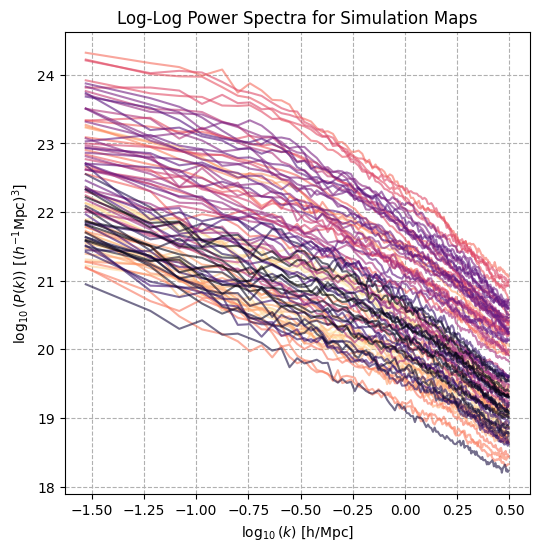

Generated log-log plot of power spectra with a colormap.
Power Spectra shape: (100, 127)


In [27]:
# Plotting power spectra from cleaned sample
plt.figure(figsize=(6, 6))

cmap_0 = plt.cm.magma
cmap = cmap_0.reversed()

for i in range(all_pk_values.shape[0]):
    plt.plot(np.log10(k_bins_common), np.log10(all_pk_values[i, :]),
             alpha=0.6, color=cmap(i / all_pk_values.shape[0]))

plt.xlabel(r'$\log_{10}(k)$ [h/Mpc]')
plt.ylabel(r'$\log_{10}(P(k))$ [($h^{-1}$Mpc)$^3$]')
plt.title('Log-Log Power Spectra for Simulation Maps')
plt.grid(True, linestyle='--', alpha=1)
plt.show()

print("Generated log-log plot of power spectra with a colormap.")
print(f"Power Spectra shape: {all_pk_values.shape}")

# Task
Modify the plotting code in cell `11023fbf` to correctly display distinct labels for the 68%, 95.4%, and 99.7% confidence intervals in the legend of the triangle plot. This involves changing the `contour_levels` argument to a list `[0.68, 0.954, 0.997]`, creating custom `matplotlib.patches.Patch` objects with appropriate colors and labels for each confidence level, and using `plt.legend()` to include these custom entries in the plot's legend. Verify that the regenerated plot clearly shows these confidence interval labels.

## Modify Plotting Code for Confidence Interval Labels

### Subtask:
Update the code in cell `11023fbf` to first correct the `contour_levels` argument to be a list instead of a set. Then, generate `matplotlib.patches.Patch` objects for each confidence level (0.68, 0.954, 0.997) with appropriate colors and labels, and use `plt.legend()` to display these custom legend entries alongside the existing plot.


**Reasoning**:
The subtask requires modifying the code in cell `11023fbf` to update `contour_levels` to a list and add custom legend entries using `matplotlib.patches.Patch` objects for different confidence intervals.

